In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.metrics import MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError
from math import sqrt
import numpy as np
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt

In [2]:
data_for_lstm = pd.read_csv("modeling_data_2.csv")

In [3]:
data_for_lstm = data_for_lstm.dropna()

In [4]:
data_for_lstm = data_for_lstm.drop(columns=['Date'])

In [5]:
# Define target variable
target = data_for_lstm['Retail']

# Define features - excluding target variable
features = data_for_lstm.drop(columns=['Wholesale','Retail'])

# Splitting the data into train and test sets while maintaining temporal order
train_size = int(len(features) * 0.7)
validation_size = int(len(features) * 0.15)
test_size = len(features) - train_size - validation_size

train_features, test_features = features[:train_size], features[train_size:]
train_target, test_target = target[:train_size], target[train_size:]

validation_features, test_features = test_features[:validation_size], test_features[validation_size:]
validation_target, test_target = test_target[:validation_size], test_target[validation_size:]

# Verifying the sizes of each set
(train_features.shape, validation_features.shape, test_features.shape), (train_target.shape, validation_target.shape, test_target.shape)

(((14301, 10), (3064, 10), (3066, 10)), ((14301,), (3064,), (3066,)))

In [6]:
# Reshaping input data for LSTM [samples, time steps, features]
# Assuming a time step of 1 for simplicity in this initial model
train_X = train_features.values.reshape((train_features.shape[0], 1, train_features.shape[1]))
validation_X = validation_features.values.reshape((validation_features.shape[0], 1, validation_features.shape[1]))
test_X = test_features.values.reshape((test_features.shape[0], 1, test_features.shape[1]))

In [7]:
def create_model():
    model = Sequential()
    # Assuming train_X is your feature data
    model.add(LSTM(units=50, activation='tanh', input_shape=(train_X.shape[1], train_X.shape[2])))  # Adjust input shape
    model.add(Dropout(0.2))
    model.add(Dense(1))  # Predicting Wholesale prices
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

In [8]:
# Instantiate the model
model = create_model()

# Summary of the model (optional, to check the structure)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                12200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 12,251
Trainable params: 12,251
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Train the model with the grid search parameters
history = model.fit(train_X, train_target, 
                    epochs=20,             # Number of epochs set to 20
                    batch_size=64,          # Batch size of 64
                    validation_data=(validation_X, validation_target), 
                    verbose=2)              # Verbose set to 2 for detailed output

Epoch 1/20
224/224 - 10s - loss: 0.0016 - val_loss: 5.9180e-04 - 10s/epoch - 47ms/step
Epoch 2/20
224/224 - 1s - loss: 9.0152e-04 - val_loss: 4.9815e-04 - 972ms/epoch - 4ms/step
Epoch 3/20
224/224 - 1s - loss: 7.7524e-04 - val_loss: 4.3200e-04 - 1s/epoch - 6ms/step
Epoch 4/20
224/224 - 1s - loss: 7.2466e-04 - val_loss: 4.5088e-04 - 923ms/epoch - 4ms/step
Epoch 5/20
224/224 - 1s - loss: 6.7424e-04 - val_loss: 4.0438e-04 - 879ms/epoch - 4ms/step
Epoch 6/20
224/224 - 1s - loss: 6.5452e-04 - val_loss: 4.0152e-04 - 886ms/epoch - 4ms/step
Epoch 7/20
224/224 - 1s - loss: 6.2985e-04 - val_loss: 3.8222e-04 - 996ms/epoch - 4ms/step
Epoch 8/20
224/224 - 1s - loss: 6.1708e-04 - val_loss: 3.8630e-04 - 893ms/epoch - 4ms/step
Epoch 9/20
224/224 - 1s - loss: 6.1916e-04 - val_loss: 4.0652e-04 - 896ms/epoch - 4ms/step
Epoch 10/20
224/224 - 1s - loss: 6.0265e-04 - val_loss: 3.7378e-04 - 977ms/epoch - 4ms/step
Epoch 11/20
224/224 - 1s - loss: 5.9889e-04 - val_loss: 3.8492e-04 - 896ms/epoch - 4ms/step
Epoc

In [10]:
test_predictions = model.predict(test_X)


96/96 [==============================] - 1s 3ms/step


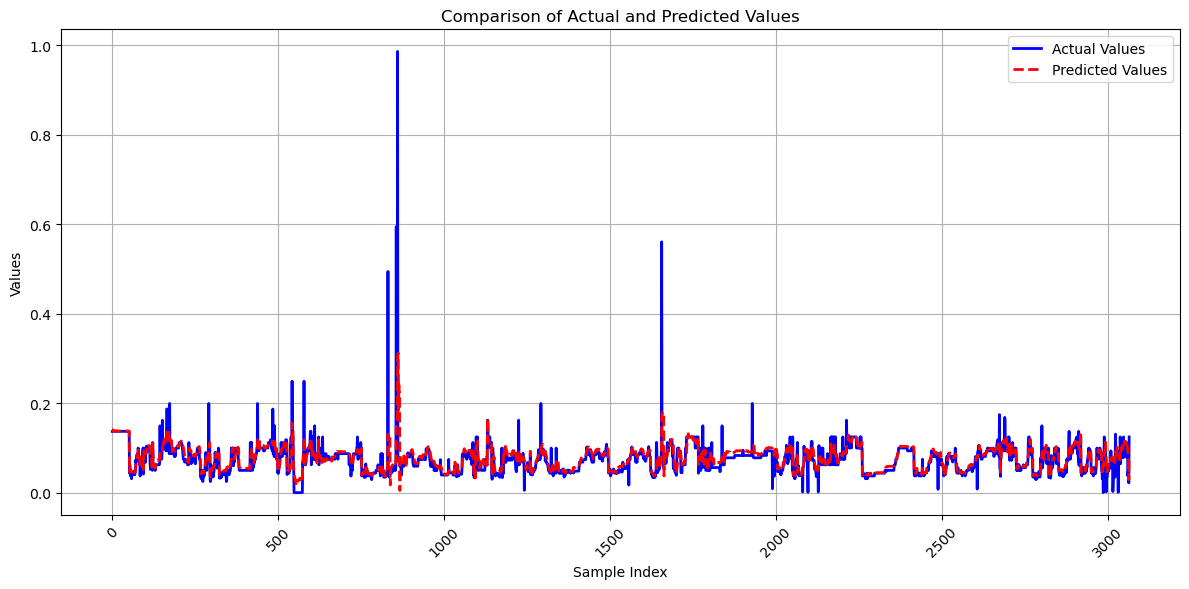

In [11]:
# Flatten the arrays to ensure they are 1D
actual = np.array(test_target).flatten()  # Flattening the actual values
predicted = np.array(test_predictions).flatten()  # Flattening the predicted values

# Creating the plot
plt.figure(figsize=(12, 6))
plt.plot(actual, label='Actual Values', color='blue', linestyle='-', linewidth=2)
plt.plot(predicted, label='Predicted Values', color='red', linestyle='--', linewidth=2)
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)  # Add grid for better readability
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability (optional)
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()